## Titanic - Machine Learning from Disaster

In this project, we aim to predict the survival of passengers aboard the Titanic using machine learning techniques. The dataset includes various features about the passengers, such as age, sex, class, and others, which we will use to determine if a passenger survived or not.

We will start by preprocessing the data, handling missing values, and encoding categorical variables. Then, we will train multiple machine learning models, such as Random Forest, Gradient Boosting, XGBoost, and an ensemble model, to predict survival. The models will be evaluated based on their performance using metrics like accuracy, precision, recall, and AUC.

After evaluating the models, we will select the best-performing one and save it for deployment, allowing us to predict the survival of new passengers in the future.

#### Install important libraries

In [3]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost joblib

#### Import required libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import joblib

#### Load Data

In [7]:
# Step 1: Load Data
train = pd.read_csv("C:/Users/sowjanya/Desktop/Data Science Projects/Titanic - Machine Learning from Disaster/Data/train.csv")
test = pd.read_csv("C:/Users/sowjanya/Desktop/Data Science Projects/Titanic - Machine Learning from Disaster/Data/test.csv")


#### Exploratory Data Analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.48659

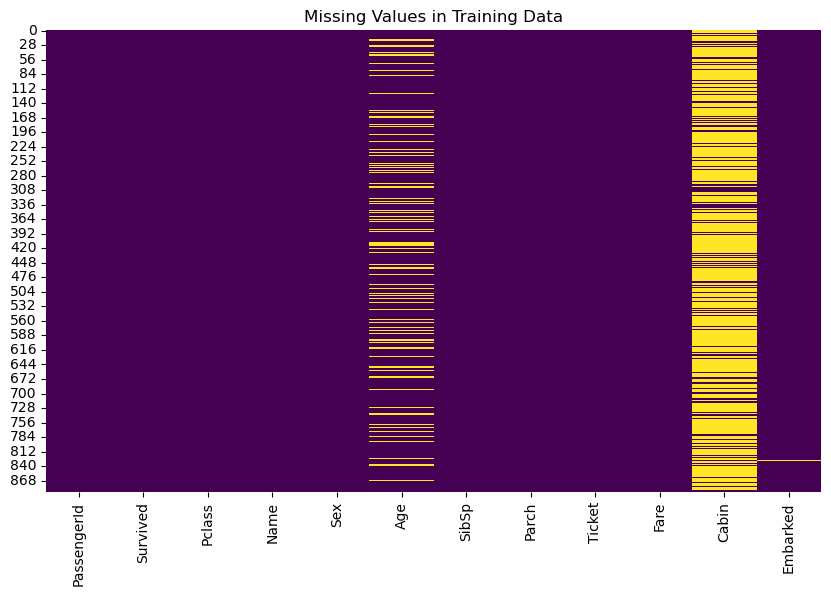

In [9]:
# Step 2: Exploratory Data Analysis (EDA)

# Summary statistics and data types
print(train.info())  # Data types and non-null counts
print(train.describe())  # Summary statistics for numerical columns

# Missing data visualization
plt.figure(figsize=(10, 6))
sns.heatmap(train.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Training Data')
plt.show()


#### Distribution of numerical variables

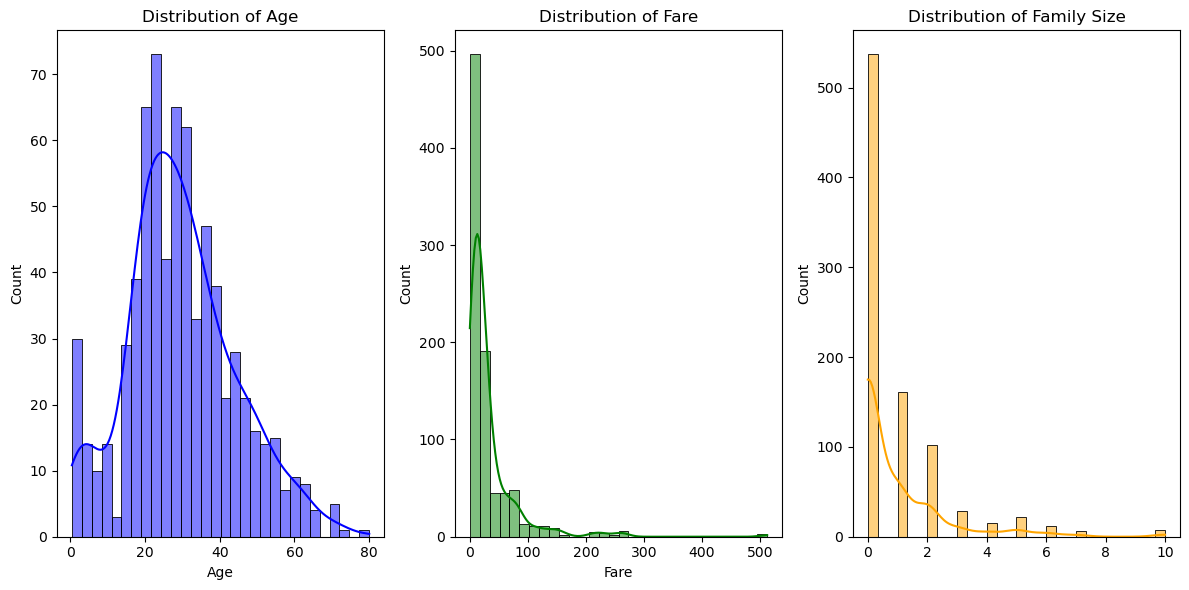

In [11]:
# Distribution of numerical variables (Age, Fare, FamilySize)
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.histplot(train['Age'], kde=True, bins=30, color='blue')
plt.title('Distribution of Age')
plt.subplot(1, 3, 2)
sns.histplot(train['Fare'], kde=True, bins=30, color='green')
plt.title('Distribution of Fare')
plt.subplot(1, 3, 3)
sns.histplot(train['SibSp'] + train['Parch'], kde=True, bins=30, color='orange')
plt.title('Distribution of Family Size')
plt.tight_layout()
plt.show()


#### Count plots for categorical features

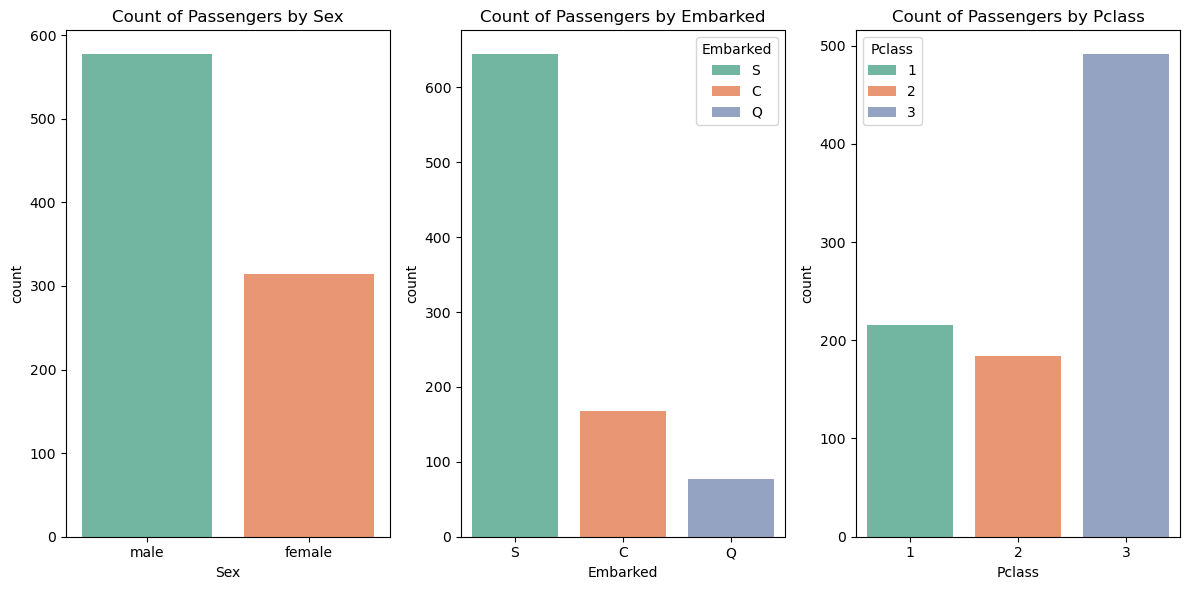

In [13]:
# Count plots for categorical features (Sex, Embarked, Pclass)
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.countplot(x='Sex', data=train, hue='Sex', palette='Set2')
plt.title('Count of Passengers by Sex')
plt.subplot(1, 3, 2)
sns.countplot(x='Embarked', data=train, hue='Embarked', palette='Set2')
plt.title('Count of Passengers by Embarked')
plt.subplot(1, 3, 3)
sns.countplot(x='Pclass', data=train, hue='Pclass', palette='Set2')
plt.title('Count of Passengers by Pclass')
plt.tight_layout()
plt.show()


#### Survival by Sex

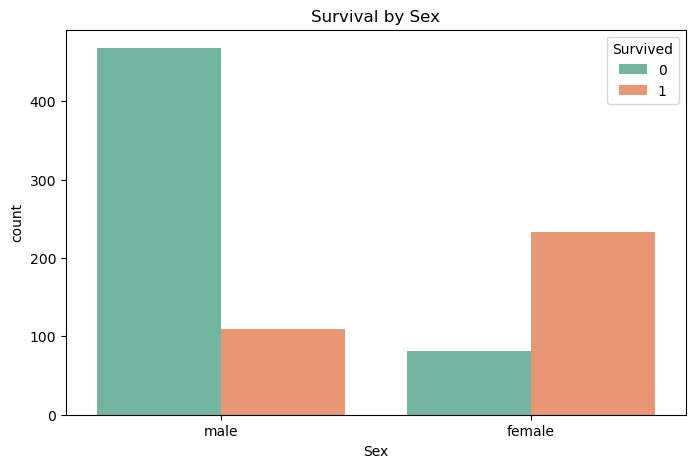

In [15]:
# Survival by Sex
plt.figure(figsize=(8, 5))
sns.countplot(x='Sex', hue='Survived', data=train, palette='Set2')
plt.title('Survival by Sex')
plt.show()


#### Correlation heatmap

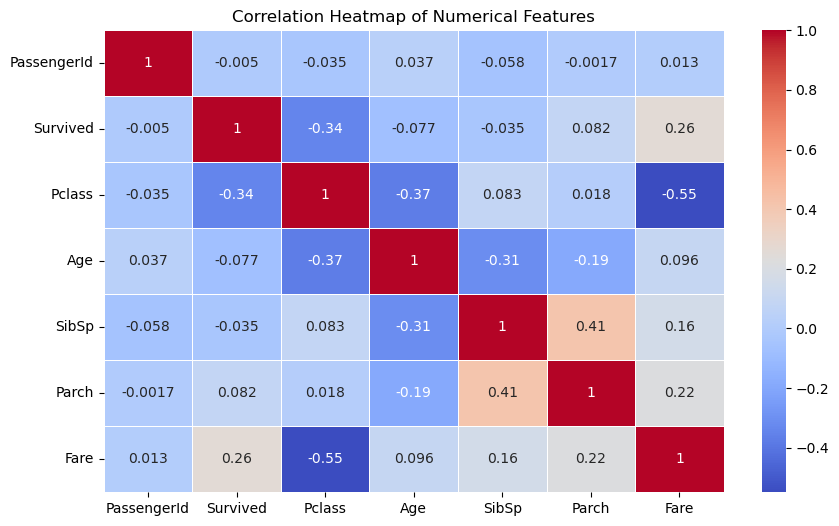

In [17]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
numeric_columns = train.select_dtypes(include=['float64', 'int64']).columns
corr = train[numeric_columns].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


#### 3.Data Preprocessing

In [19]:
# Step 3: Data Preprocessing

# Handle missing values
train['Age'] = train['Age'].fillna(train['Age'].median())  # Median imputation for Age
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])  # Mode imputation for Embarked
test['Age'] = test['Age'].fillna(test['Age'].median())
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

# Feature Engineering: Create FamilySize and IsAlone
train['FamilySize'] = train['SibSp'] + train['Parch']
test['FamilySize'] = test['SibSp'] + test['Parch']
train['IsAlone'] = (train['FamilySize'] == 0).astype(int)
test['IsAlone'] = (test['FamilySize'] == 0).astype(int)

# Extract titles from Name
def extract_title(name):
    return name.split(',')[1].split('.')[0].strip()

train['Title'] = train['Name'].apply(extract_title)
test['Title'] = test['Name'].apply(extract_title)

# Combine train and test datasets to ensure consistent encoding
combined = pd.concat([train, test], axis=0)

# Handle rare titles by grouping them into a single category
rare_titles = ['Dona', 'Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']
combined['Title'] = combined['Title'].replace(rare_titles, 'Rare')

# Encode 'Sex', 'Embarked', and 'Title'
label_encoder = LabelEncoder()
combined['Sex'] = label_encoder.fit_transform(combined['Sex'])
combined['Embarked'] = label_encoder.fit_transform(combined['Embarked'])
combined['Title'] = label_encoder.fit_transform(combined['Title'])

# Split the combined data back into train and test sets
train = combined.loc[combined.index.isin(train.index)].copy()
test = combined.loc[combined.index.isin(test.index)].copy()


#### 4. Features and Target Variable

In [21]:
# Step 4: Features and Target Variable

# Check for missing values in target variable
print("Missing values in target variable before dropping rows:", train['Survived'].isnull().sum())

# Drop rows with missing 'Survived' target variable
train = train.dropna(subset=['Survived'])

# Recreate features and target variable after dropping missing 'Survived'
X_train = train.drop(columns=['Survived', 'PassengerId', 'Name', 'Cabin', 'Ticket'])
y_train = train['Survived']
X_test = test.drop(columns=['PassengerId', 'Name', 'Cabin', 'Ticket'])

# Split the training data into train and validation sets
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)


Missing values in target variable before dropping rows: 418


#### 5. Model Training

In [23]:
# Step 5: Model Training

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_split, y_train_split)

# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_split, y_train_split)

# XGBoost
xgb_model = XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_split, y_train_split)

# Voting Classifier (Ensemble)
ensemble_model = VotingClassifier(
    estimators=[('rf', rf_model), ('gb', gb_model), ('xgb', xgb_model)], voting='soft'
)
ensemble_model.fit(X_train_split, y_train_split)


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            featu...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

#### 6. Model Evaluation - Random Forest

Evaluating Random Forest Model
Confusion Matrix for Random Forest:
[[91 14]
 [14 60]]


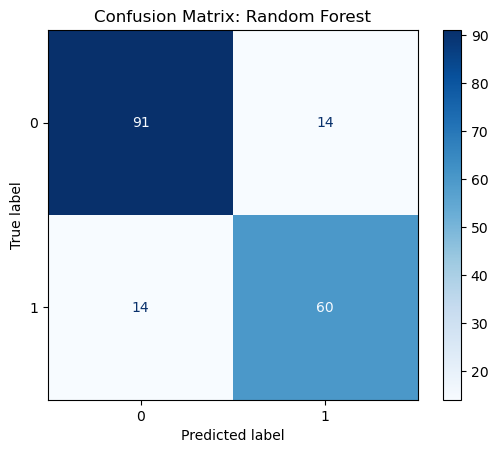

Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87       105
         1.0       0.81      0.81      0.81        74

    accuracy                           0.84       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.84      0.84      0.84       179



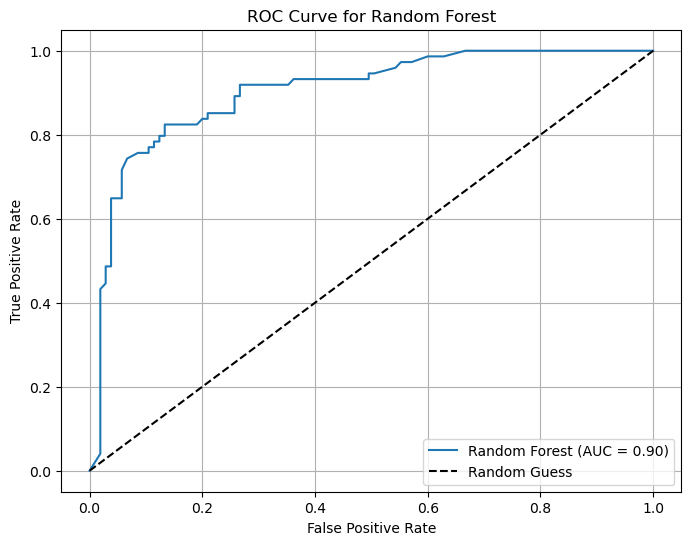

In [25]:
# Step 6: Model Evaluation - Random Forest
print("Evaluating Random Forest Model")

# Predict on validation set
y_valid_pred_rf = rf_model.predict(X_valid_split)

# Confusion Matrix
print(f"Confusion Matrix for Random Forest:")
cm_rf = confusion_matrix(y_valid_split, y_valid_pred_rf)
print(cm_rf)

# Plot confusion matrix for Random Forest
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=[0, 1])
disp_rf.plot(cmap='Blues')
plt.title(f"Confusion Matrix: Random Forest")
plt.show()

# Classification Report for Random Forest
print(f"Classification Report for Random Forest:")
print(classification_report(y_valid_split, y_valid_pred_rf))

# ROC Curve for Random Forest
y_valid_prob_rf = rf_model.predict_proba(X_valid_split)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_valid_split, y_valid_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title(f'ROC Curve for Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()



#### Gradient Boosting

Evaluating Gradient Boosting Model
Confusion Matrix for Gradient Boosting:
[[91 14]
 [21 53]]


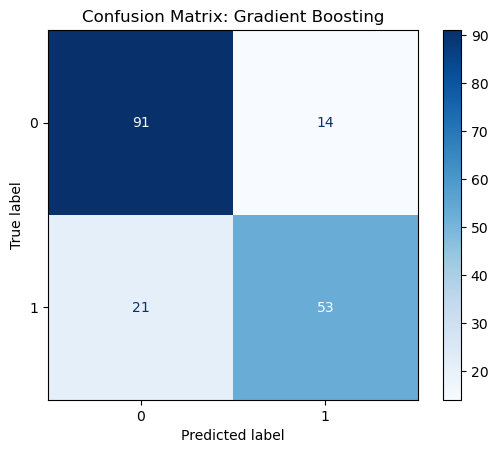

Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84       105
         1.0       0.79      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



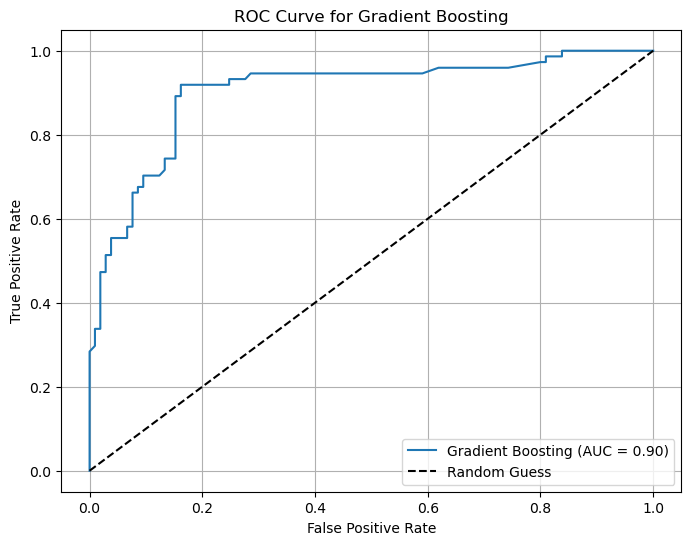

In [27]:
# Step 6: Model Evaluation - Gradient Boosting
print("Evaluating Gradient Boosting Model")

# Predict on validation set
y_valid_pred_gb = gb_model.predict(X_valid_split)

# Confusion Matrix
print(f"Confusion Matrix for Gradient Boosting:")
cm_gb = confusion_matrix(y_valid_split, y_valid_pred_gb)
print(cm_gb)

# Plot confusion matrix for Gradient Boosting
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=[0, 1])
disp_gb.plot(cmap='Blues')
plt.title(f"Confusion Matrix: Gradient Boosting")
plt.show()

# Classification Report for Gradient Boosting
print(f"Classification Report for Gradient Boosting:")
print(classification_report(y_valid_split, y_valid_pred_gb))

# ROC Curve for Gradient Boosting
y_valid_prob_gb = gb_model.predict_proba(X_valid_split)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(y_valid_split, y_valid_prob_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title(f'ROC Curve for Gradient Boosting')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()



#### XGBoost

Evaluating XGBoost Model
Confusion Matrix for XGBoost:
[[88 17]
 [18 56]]


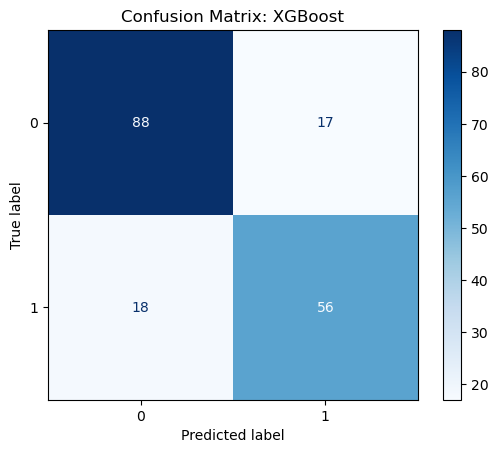

Classification Report for XGBoost:
              precision    recall  f1-score   support

         0.0       0.83      0.84      0.83       105
         1.0       0.77      0.76      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179



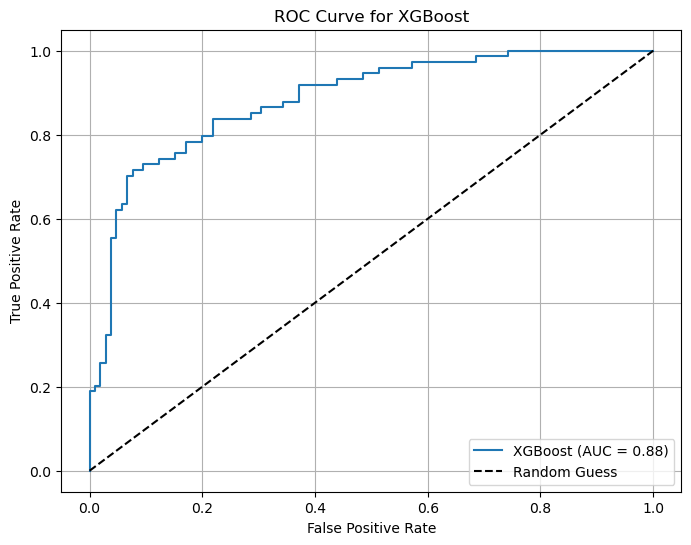

In [29]:
# Step 6: Model Evaluation - XGBoost
print("Evaluating XGBoost Model")

# Predict on validation set
y_valid_pred_xgb = xgb_model.predict(X_valid_split)

# Confusion Matrix
print(f"Confusion Matrix for XGBoost:")
cm_xgb = confusion_matrix(y_valid_split, y_valid_pred_xgb)
print(cm_xgb)

# Plot confusion matrix for XGBoost
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=[0, 1])
disp_xgb.plot(cmap='Blues')
plt.title(f"Confusion Matrix: XGBoost")
plt.show()

# Classification Report for XGBoost
print(f"Classification Report for XGBoost:")
print(classification_report(y_valid_split, y_valid_pred_xgb))

# ROC Curve for XGBoost
y_valid_prob_xgb = xgb_model.predict_proba(X_valid_split)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_valid_split, y_valid_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title(f'ROC Curve for XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()



#### Ensemble (Voting Classifier)

Evaluating Ensemble Model
Confusion Matrix for Ensemble Model:
[[93 12]
 [18 56]]


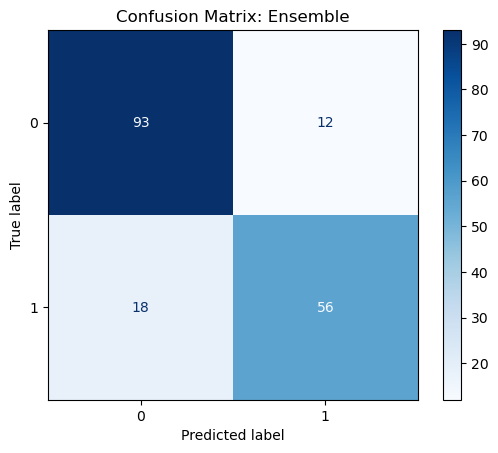

Classification Report for Ensemble Model:
              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86       105
         1.0       0.82      0.76      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



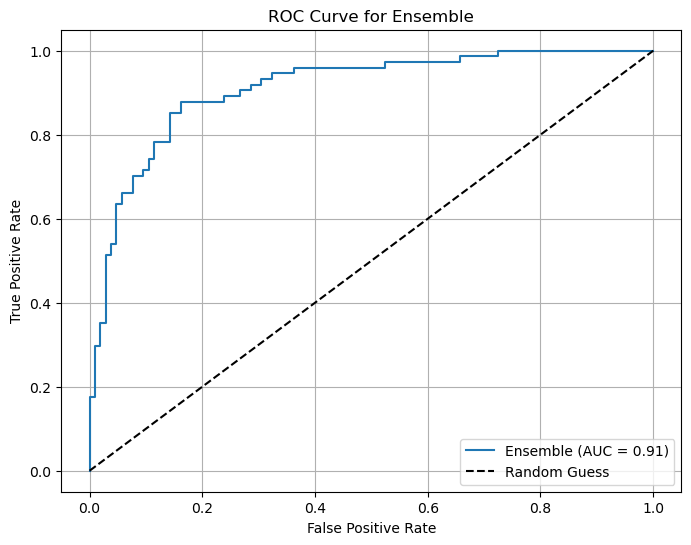

In [31]:
# Step 6: Model Evaluation - Ensemble (Voting Classifier)
print("Evaluating Ensemble Model")

# Predict on validation set
y_valid_pred_ensemble = ensemble_model.predict(X_valid_split)

# Confusion Matrix
print(f"Confusion Matrix for Ensemble Model:")
cm_ensemble = confusion_matrix(y_valid_split, y_valid_pred_ensemble)
print(cm_ensemble)

# Plot confusion matrix for Ensemble Model
disp_ensemble = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble, display_labels=[0, 1])
disp_ensemble.plot(cmap='Blues')
plt.title(f"Confusion Matrix: Ensemble")
plt.show()

# Classification Report for Ensemble Model
print(f"Classification Report for Ensemble Model:")
print(classification_report(y_valid_split, y_valid_pred_ensemble))

# ROC Curve for Ensemble Model
y_valid_prob_ensemble = ensemble_model.predict_proba(X_valid_split)[:, 1]
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_valid_split, y_valid_prob_ensemble)
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)

plt.figure(figsize=(8, 6))
plt.plot(fpr_ensemble, tpr_ensemble, label=f'Ensemble (AUC = {roc_auc_ensemble:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title(f'ROC Curve for Ensemble')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


#### Feature Importance Visualization (Random Forest)

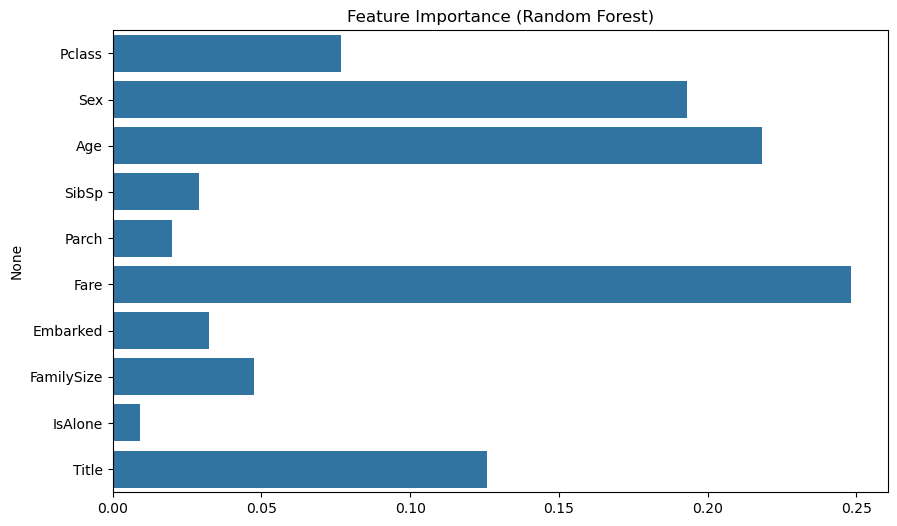

In [33]:
# Feature Importance Visualization (Random Forest)
importances = rf_model.feature_importances_
feature_names = X_train.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance (Random Forest)')
plt.show()


#### 7. Finalize the Best Model

In [35]:
# Step 7: Finalize the Best Model
# Compare models and select the best based on AUC or Accuracy
model_performance = {
    'Random Forest': roc_auc_rf,
    'Gradient Boosting': roc_auc_gb,
    'XGBoost': roc_auc_xgb,
    'Ensemble': roc_auc_ensemble
}

best_model_name = max(model_performance, key=model_performance.get)
print(f"The best model based on AUC is: {best_model_name}")

# Save the best model to disk using joblib
if best_model_name == 'Random Forest':
    best_model = rf_model
elif best_model_name == 'Gradient Boosting':
    best_model = gb_model
elif best_model_name == 'XGBoost':
    best_model = xgb_model
else:
    best_model = ensemble_model

# Define the path for saving the model
model_save_path = "C:/Users/sowjanya/Desktop/Data Science Projects/Titanic - Machine Learning from Disaster/models/best_titanic_model.pkl"

# Save the best model using joblib
joblib.dump(best_model, model_save_path)
print(f"The best model has been saved at: {model_save_path}")

The best model based on AUC is: Ensemble
The best model has been saved at: C:/Users/sowjanya/Desktop/Data Science Projects/Titanic - Machine Learning from Disaster/models/best_titanic_model.pkl
